In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import ndarray
from pandas import DataFrame
import os
import glob
from functools import reduce
import json
from keras.utils import to_categorical

In [17]:
_frequency = 200

In [24]:
class Dataset:
    def __init__(self, is_train: bool = True, window_time: int = 1):
        self.x_fields = ["acc_gx", "acc_gy", "acc_gz", "gyr_gx", "gyr_gy", "gyr_gz"]  # "timestamp", "fixingPoint",
        self.y_fields = ["exerciseType"]

        # self.df = load_train() if is_train else load_test()
        self.df: DataFrame = DataFrame()
        self.window_size = window_time * _frequency
        self.x = np.ndarray(shape=(0, self.window_size, len(self.x_fields)))
        self.y = np.ndarray(shape=(0, 3))
        self.x_feature = np.ndarray(shape=(0, 1))
        self.y_feature = np.ndarray(shape=(0, 1))
        self._load_data(is_train)
        self._feature_extraction()

    def _load_from_path(self, path: str):
        json_dir = path
        json_pattern = os.path.join(json_dir, '*.json')
        file_list = glob.glob(json_pattern)
        dfs = []

        def convert(data, count):
            local_buffer = []

            def lamb(x: dict):
                x['id'] = count
                x["acc" + '_gx'] = x.pop('gx')
                x["acc" + '_gy'] = x.pop('gy')
                x["acc" + '_gz'] = x.pop('gz')
                return x

            size = min(len(data['accelerometerValue']), len(data['gyroscopeValue']))
            size = size - size % self.window_size  # кейс, когда данных не хватает, мы тогда обрезаем датасет под целочисленный размер окна
            data['accelerometerValue'] = data['accelerometerValue'][:size]
            data['gyroscopeValue'] = data['gyroscopeValue'][:size]

            c = list(map(lamb, data['accelerometerValue']))

            for i in range(size):
                c[i]["gyr" + '_gx'] = data['gyroscopeValue'][i]['gx']
                c[i]["gyr" + '_gy'] = data['gyroscopeValue'][i]['gy']
                c[i]["gyr" + '_gz'] = data['gyroscopeValue'][i]['gz']

            return list(c)

        count = 0
        for file in file_list:

            buffer = []
            with open(file) as f:
                reading = json.loads(f.read())

            for line in reading:
                dat = convert(line['data'], count)[:_frequency * line['duration']]
                pd_data = pd.json_normalize(dat)
                if pd_data.shape[1] == 0:
                    continue
                pd_data_x = pd_data[self.x_fields].to_numpy().reshape(-1, self.window_size, len(self.x_fields))
                self.x = np.concatenate([self.x, pd_data_x])
                # temp_y = np.concatenate(
                #     [Dataset.typeBreathingNP[Dataset.typeBreathingDic[line["typeBreathing"]]].reshape(1, -1) for _ in
                #      range(pd_data_x.shape[0])])
                # self.y = np.concatenate([self.y, temp_y])
                buffer.append(dat)
                count += 1

            if len(buffer) == 0: # фикс для Сани
                continue
            buffer = reduce(lambda x, y: x + y, buffer)
            json_data = pd.json_normalize(buffer)

            dfs.append(json_data)
            buffer.clear()
        df = pd.concat(dfs)
        return df

    def _load_data(self, is_train: bool = True):
        self.df = self._load_from_path("data/train") if is_train else self._load_from_path("data/test")

    def _feature_extraction(self):
        new_x = []
        for i in self.x:  # По каждой строке
            i: ndarray  # (Размер окна _1000, количество параметром _6)

            # ================ чтобы набить новые признаки, редактировать в этом окне ========================
            res = []
            n = i.shape[-1]
            for k in range(n):
                a: ndarray = i[:, k]
                res.append(a.std())
                res.append(a.mean())
                res.append(a.max())
                res.append(a.min())
                res.append(a.var())

            cov1 = np.cov(i[:,0],i[:,1])
            res.append(cov1[0][1])

            cov1 = np.cov(i[:,0],i[:,2])
            res.append(cov1[0][1])

            cov1 = np.cov(i[:,1],i[:,2])
            res.append(cov1[0][1])

            cov1 = np.cov(i[:,3],i[:,4])
            res.append(cov1[0][1])

            cov1 = np.cov(i[:,3],i[:,5])
            res.append(cov1[0][1])

            cov1 = np.cov(i[:,4],i[:,5])
            res.append(cov1[0][1])

            corr1 = np.corrcoef(i[:,0],i[:,1])
            res.append(corr1[0][1])

            corr1 = np.corrcoef(i[:,0],i[:,2])
            res.append(corr1[0][1])

            corr1 = np.corrcoef(i[:,1],i[:,2])
            res.append(corr1[0][1])

            corr1 = np.corrcoef(i[:,3],i[:,4])
            res.append(corr1[0][1])

            corr1 = np.corrcoef(i[:,3],i[:,5])
            res.append(corr1[0][1])

            corr1 = np.corrcoef(i[:,4],i[:,5])
            res.append(corr1[0][1])


            # ================================================================================================
            new_x.append(np.array(res).reshape(1, -1))
            res.clear()

        self.x_feature = np.concatenate(new_x)
        new_y = []
        for i in self.y:
            for j in range(i.shape[-1]):
                if i[j] == 1:
                    new_y.append(j)
        self.y_feature = np.array(new_y)

In [19]:
to_categorical([0, 1, 2], 3)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [22]:
fixingPointDic = {"CHEST": 0, "BELLY": 1}
fixingPointDic

{'CHEST': 0, 'BELLY': 1}

In [23]:
fixingPointDicRev = {item: element for element, item in fixingPointDic.items()}
fixingPointDicRev

{0: 'CHEST', 1: 'BELLY'}

In [ ]:
class Dataset_v2:
    typeBreathingDic = {"CHEST": 0, "DIAPHRAGMATIC": 1, "MIXED": 2}
    typeBreathingDicRev = {item: element for element, item in typeBreathingDic.items()}
    typeBreathingNP = to_categorical([0, 1, 2], 3)
    fixingPointDic = {"CHEST": 0, "BELLY": 1}
    fixingPointDicRev = {item: element for element, item in fixingPointDic.items()}

    def __init__(self, is_train: bool = True, window_time: int = 1):
        self.x_fields = ["acc_gx", "acc_gy", "acc_gz", "gyr_gx", "gyr_gy", "gyr_gz"]  # "timestamp", "fixingPoint",
        self.y_fields = ["typeBreathing"]

        # self.df = load_train() if is_train else load_test()
        self.df: DataFrame = DataFrame()
        self.window_size = window_time * _frequency
        self.x = np.ndarray(shape=(0, self.window_size, len(self.x_fields)))
        self.y = np.ndarray(shape=(0, 3))
        self.x_feature = np.ndarray(shape=(0, 1))
        self.y_feature = np.ndarray(shape=(0, 1))
        self._load_data(is_train)
        self._feature_extraction()

    def _load_from_path(self, path: str):
        json_dir = path
        json_pattern = os.path.join(json_dir, '*.json')
        file_list = glob.glob(json_pattern)
        dfs = []

        def convert(data, fixingPoint, typeBreathing, count):
            local_buffer = []

            def lamb(x: dict):
                x['id'] = count
                x['typeBreathing'] = Dataset.typeBreathingDic[typeBreathing]
                x["fixingPoint"] = Dataset.fixingPointDic[fixingPoint]
                x["acc" + '_gx'] = x.pop('gx')
                x["acc" + '_gy'] = x.pop('gy')
                x["acc" + '_gz'] = x.pop('gz')
                return x

            size = min(len(data['accelerometerValue']), len(data['gyroscopeValue']))
            size = size - size % self.window_size  # кейс, когда данных не хватает, мы тогда обрезаем датасет под целочисленный размер окна
            data['accelerometerValue'] = data['accelerometerValue'][:size]
            data['gyroscopeValue'] = data['gyroscopeValue'][:size]

            c = list(map(lamb, data['accelerometerValue']))

            for i in range(size):
                c[i]["gyr" + '_gx'] = data['gyroscopeValue'][i]['gx']
                c[i]["gyr" + '_gy'] = data['gyroscopeValue'][i]['gy']
                c[i]["gyr" + '_gz'] = data['gyroscopeValue'][i]['gz']

            return list(c)

        count = 0
        for file in file_list:

            buffer = []
            with open(file) as f:
                reading = json.loads(f.read())['list']

            for line in reading:
                if line["fixingPoint"] == "CHEST":  # скипнули все записи, где зафиксировано на груди
                    continue
                dat = convert(line['data'], line['fixingPoint'], line['typeBreathing'], count)[
                      :_frequency * line['duration']['duration']]
                pd_data = pd.json_normalize(dat)
                if pd_data.shape[1] == 0:
                    continue
                pd_data_x = pd_data[self.x_fields].to_numpy().reshape(-1, self.window_size, len(self.x_fields))
                self.x = np.concatenate([self.x, pd_data_x])
                temp_y = np.concatenate(
                    [Dataset.typeBreathingNP[Dataset.typeBreathingDic[line["typeBreathing"]]].reshape(1, -1) for _ in
                     range(pd_data_x.shape[0])])
                self.y = np.concatenate([self.y, temp_y])
                buffer.append(dat)
                count += 1

            if len(buffer) == 0: # фикс для Сани
                continue
            buffer = reduce(lambda x, y: x + y, buffer)
            json_data = pd.json_normalize(buffer)

            dfs.append(json_data)
            buffer.clear()
        df = pd.concat(dfs)
        return df

    def _load_data(self, is_train: bool = True):
        self.df = self._load_from_path("data/train") if is_train else self._load_from_path("data/test")

    def _feature_extraction(self):
        new_x = []
        for i in self.x:  # По каждой строке
            i: ndarray  # (Размер окна _1000, количество параметром _6)

            # ================ чтобы набить новые признаки, редактировать в этом окне ========================
            res = []
            n = i.shape[-1]
            for k in range(n):
                a: ndarray = i[:, k]
                res.append(a.std())
                res.append(a.mean())
                res.append(a.max())
                res.append(a.min())
                res.append(a.var())

            cov1 = np.cov(i[:,0],i[:,1])
            res.append(cov1[0][1])

            cov1 = np.cov(i[:,0],i[:,2])
            res.append(cov1[0][1])

            cov1 = np.cov(i[:,1],i[:,2])
            res.append(cov1[0][1])

            cov1 = np.cov(i[:,3],i[:,4])
            res.append(cov1[0][1])

            cov1 = np.cov(i[:,3],i[:,5])
            res.append(cov1[0][1])

            cov1 = np.cov(i[:,4],i[:,5])
            res.append(cov1[0][1])

            corr1 = np.corrcoef(i[:,0],i[:,1])
            res.append(corr1[0][1])

            corr1 = np.corrcoef(i[:,0],i[:,2])
            res.append(corr1[0][1])

            corr1 = np.corrcoef(i[:,1],i[:,2])
            res.append(corr1[0][1])

            corr1 = np.corrcoef(i[:,3],i[:,4])
            res.append(corr1[0][1])

            corr1 = np.corrcoef(i[:,3],i[:,5])
            res.append(corr1[0][1])

            corr1 = np.corrcoef(i[:,4],i[:,5])
            res.append(corr1[0][1])


            # ================================================================================================
            new_x.append(np.array(res).reshape(1, -1))
            res.clear()

        self.x_feature = np.concatenate(new_x)
        new_y = []
        for i in self.y:
            for j in range(i.shape[-1]):
                if i[j] == 1:
                    new_y.append(j)
        self.y_feature = np.array(new_y)

In [25]:
train_ds = Dataset(is_train=True)

In [29]:
train_ds.x[0]

array([[ 8.453926  , -3.4524388 , -4.331111  , -0.05925393,  1.0030408 ,
         0.42394048],
       [ 8.456321  , -3.5098996 , -4.357447  , -0.05925393,  1.0030408 ,
         0.42394048],
       [ 8.475474  , -3.5793316 , -4.453215  , -0.05925393,  1.0030408 ,
         0.42394048],
       ...,
       [-0.06703765, -7.52737   , -6.361394  , -0.2510656 , -0.8338311 ,
         3.6529741 ],
       [-0.4357447 , -7.6255326 , -6.6415157 , -0.39645153, -0.70738196,
         3.5802813 ],
       [-0.8499416 , -7.6015906 , -6.789956  , -0.5015204 , -0.6560693 ,
         3.5399642 ]])

In [11]:
def plot_acc(data):
    plt.plot(data[:,0])
    plt.plot(data[:,1])
    plt.plot(data[:,2])
    plt.title(f'data accelerometer')
    plt.xlabel('time')
    plt.ylabel(f'acc')
    plt.legend(['gx', 'gy', 'gz'], loc='upper left')

def plot_gyr(data):
    plt.plot(data[:,3])
    plt.plot(data[:,4])
    plt.plot(data[:,5])
    plt.title(f'data gyroscope')
    plt.xlabel('time')
    plt.ylabel(f'gyr')
    plt.legend(['gx', 'gy', 'gz'], loc='upper left')

def plot_acc_df(data):
    plt.plot(data["timestamp"], data["acc_gx"])
    plt.plot(data["timestamp"], data["acc_gy"])
    plt.plot(data["timestamp"], data["acc_gz"])
    plt.title(f'data accelerometer')
    plt.xlabel('time')
    plt.ylabel(f'acc')
    plt.legend(['gx', 'gy', 'gz'], loc='upper left')

def plot_gyr_df(data):
    plt.plot(data["timestamp"],data["gyr_gx"])
    plt.plot(data["timestamp"],data["gyr_gy"])
    plt.plot(data["timestamp"],data["gyr_gz"])
    plt.title(f'data gyroscope')
    plt.xlabel('time')
    plt.ylabel(f'gyr')
    plt.legend(['gx', 'gy', 'gz'], loc='upper left')

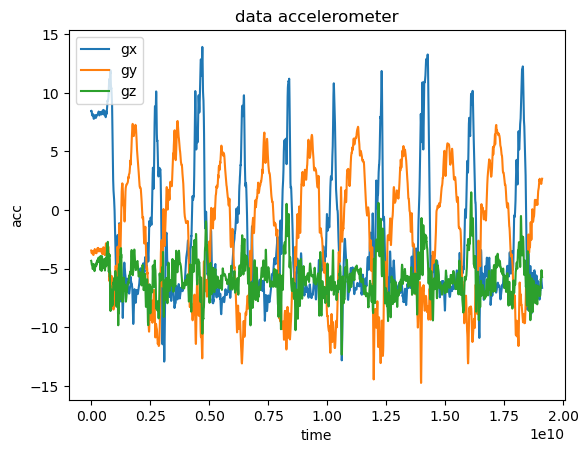

In [12]:
plot_acc_df(train_ds.df)

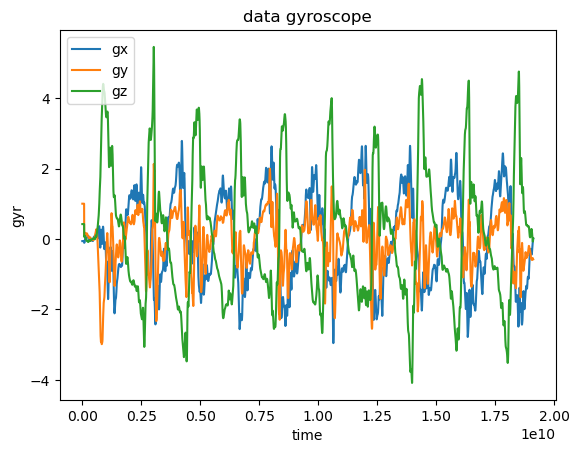

In [13]:
plot_gyr_df(train_ds.df)

2023-05-01 16:13:42.619292: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
